In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pll as pll
from functools import partial
from scipy.fft import fft, fftfreq
from scipy.signal import butter, sosfiltfilt, lfilter
from typing import Callable
import warnings
warnings.filterwarnings("error")
fs = np.int32(122.88e6)  # Sampling frequency

In [6]:
def to_complement(value: np.uint16) -> np.uint16:
    return np.uint16((np.uint32(value) + 0x8000) & 0xFFFF)

def sign_extend(value: np.uint16, bits: int = 24) -> np.uint32:
    if value & 0x8000:
        return np.uint32(np.uint32(value) | 0xFFFF0000) & (2**bits - 1)
    else:
        return np.uint32(np.uint32(value) & 0x0000FFFF) & (2**bits - 1)
    
def negate(value: np.uint16) -> np.uint16:
    try:
        val = np.uint16((~value + 1) & 0xFFFF) if value != 0 else np.uint16(0)
    except:
        print("Negate Error:", value)
        val = np.uint16(0)
    return val

def negate32(value: np.uint32) -> np.uint32:
    try: 
        val = np.uint32((~value + 1) & 0xFFFFFFFF) if value != 0 else np.uint32(0)
    except:
        print("Negate32 Error:", value)
        val = np.uint32(0)
    return val

def add32u(a: np.uint32, b: np.uint32) -> np.uint32:
    try:
        val = np.uint32((np.uint64(a) + np.uint64(b)) & np.uint64(0xFFFFFFFF))
    except:
        print("Add32u Error:", a, b)
        val = np.uint32(0)
    return val

def add16u(a: np.uint16, b: np.uint16) -> np.uint16:
    try:
        val = np.uint16((np.uint32(a) + np.uint32(b)) & 0xFFFF)
    except:
        print("Add16u Error:", a, b)
        val = np.uint16(0)
    return val

def sra32(value: np.uint32, shift: int) -> np.uint32:
    if value & 0x80000000:
        return np.uint32((value >> shift) | (np.uint32(0xFFFFFFFF) << (32 - shift))) & 0xFFFFFFFF
    else:
        return np.uint32(value >> shift) & 0xFFFFFFFF
    
def sra(value: np.uint16, shift: int) -> np.uint16:
    if value & 0x8000:
        return np.uint16((value >> shift) | (np.uint16(0xFFFF) << (16 - shift))) & 0xFFFF
    else:
        return np.uint16(value >> shift) & 0xFFFF
    
def lt(a: np.uint16, b: np.uint16) -> bool:
    return (np.int16(a) < np.int16(b))

def integrator_gen(bits: int = 24) -> Callable[[np.uint16], np.uint32]:
    state: np.uint32 = 0
    def integrator(input_sample: np.uint16) -> np.uint32:
        nonlocal state
        msk = (2**bits) - 1
        state = (state + input_sample) & msk
        return state
    return integrator

def diff_gen(bits: int = 24) -> Callable[[np.uint32], np.uint32]:
    state: np.uint32 = 0
    def diff(input_sample: np.uint32) -> np.uint32:
        nonlocal state
        msk = (2**bits) - 1
        neg_state = (~state + 1 if state != 0 else 0) & msk
        output_sample = ((input_sample & msk) + neg_state) & msk
        state = input_sample & msk
        return output_sample
    return diff


def cic_gen(decimation: int = 32, stages: int = 3) -> Callable[[np.uint16], np.uint16]:
    sample_state: int = 0
    bits = stages * int(np.floor(np.log2(decimation))) + 16
    print("CIC bits:", bits)
    int1 = integrator_gen(bits=bits)
    int2 = integrator_gen(bits=bits)
    int3 = integrator_gen(bits=bits)

    diff1 = diff_gen(bits=bits)
    diff2 = diff_gen(bits=bits)
    diff3 = diff_gen(bits=bits)

    diff_out: np.uint32 = 0

    def cic(input_samples: np.uint16) -> np.uint16:
        nonlocal sample_state, int1, int2, int3
        nonlocal diff1, diff2, diff3, diff_out
        input_samples = sign_extend(input_samples, bits=bits)
        int_out = int3(int2(int1(input_samples)))

        sample_state += 1
        if sample_state == decimation:
            sample_state = 0
            diff_out = diff3(diff2(diff1(int_out)))
        return np.uint16(((diff_out & (2**bits - 1)) >> (bits - 16)) & 0xFFFF)
    return cic

def cic2_gen() -> Callable[[np.uint16], np.uint16]:
    int3_st = [np.uint32(0) for _ in range(3)]
    comb3_st = [np.uint32(0) for _ in range(3)]
    sample_state: int = 0
    bits = 28

    def cic2(input_sample: np.uint16) -> np.uint16:
        nonlocal int3_st, comb3_st, sample_state
        input_sample = sign_extend(input_sample, bits=bits)

        out1 = add32u(int3_st[0], input_sample) & (2**bits - 1)
        out2 = add32u(int3_st[1], out1) & (2**bits - 1)
        out3 = add32u(int3_st[2], out2) & (2**bits - 1)
        int3_st = [out1, out2, out3]

        diff1 = add32u(out3, negate32(comb3_st[0]) & (2**bits - 1)) & (2**bits - 1)
        diff2 = add32u(diff1, negate32(comb3_st[1]) & (2**bits - 1)) & (2**bits - 1)
        diff3 = add32u(diff2, negate32(comb3_st[2]) & (2**bits - 1)) & (2**bits - 1)

        if sample_state == 0:
            comb3_st = [out3, diff1, diff2]
        
        sample_state = (sample_state + 1) % 16
        return np.uint16(((diff3 & 0x0FFFFFFF) >> 12) & 0xFFFF)
    return cic2

def cic_upper_gen(decimation: int = 32, stages: int = 3) -> Callable[[np.uint16], np.uint16]:
    sample_state: int = 0
    bits = stages * int(np.floor(np.log2(decimation))) + 16
    int1 = integrator_gen(bits=bits)
    int2 = integrator_gen(bits=bits)
    int3 = integrator_gen(bits=bits)

    diff1 = diff_gen(bits=bits)
    diff2 = diff_gen(bits=bits)
    diff3 = diff_gen(bits=bits)

    diff_out: np.uint32 = 0

    def cic(input_sample: np.uint16) -> np.uint32:
        nonlocal sample_state, int1, int2, int3
        nonlocal diff1, diff2, diff3, diff_out
        input_sample = sign_extend(input_sample, bits=bits)

        sample_state += 1
        
        if sample_state == decimation:
            sample_state = 0
            diff_out = diff3(diff2(diff1(input_sample)))
        else:
            diff_out = 0
        
        output = int3(int2(int1(diff_out)))

        return np.uint16(((output & (2**bits - 1)) >> 3) & 0xFFFF)
    return cic

In [26]:
def cordic_atan(y: float, x: float, iterations: int = 16) -> float:
    angles = [np.arctan(2**-i) for i in range(iterations)]
    z = 0.0
    x_acc = x
    y_acc = y
    for i in range(iterations):
        s = 1.0 if y_acc < 0 else -1.0
        m = 1
        x_new = x_acc - s * (y_acc * m * (2 ** -i))
        y_new = y_acc + s * (x_acc * m * (2 ** -i))
        z = z - s * angles[i]
        x_acc = x_new
        y_acc = y_new
    return z 

def cordic_atan2(y: float, x: float, iterations: int = 16) -> float:
    if x >= 0:
        return cordic_atan(y, x, iterations)
    elif x < 0 and y >= 0:
        return cordic_atan(-y, -x, iterations) + np.pi
    elif x < 0 and y < 0:
        return cordic_atan(-y, -x, iterations) - np.pi
    
def cordic_atan_int(y: np.int16, x: np.int16, iterations: int = 16) -> np.int16:
    angles = [np.int32(np.arctan(2**-i) * (2**29)) for i in range(iterations)]
    z = np.int32(0)
    x_acc = np.int32(x) << 13
    y_acc = np.int32(y) << 13
    for i in range(iterations):
        s = 1 if y_acc < 0 else -1
        x_new = x_acc - s * (y_acc >> i)
        y_new = y_acc + s * (x_acc >> i)
        z = z - s * angles[i]
        x_acc = x_new
        y_acc = y_new
    return np.int16((z >> 16) & 0xffff)

def cordic_atan2_int(y: np.int16, x: np.int16, iterations: int = 16) -> np.int16:
    if x >= 0:
        return cordic_atan_int(y, x, iterations)
    elif x < 0 and y >= 0:
        return cordic_atan_int(-y, -x, iterations) + (np.pi * 2**13)
    elif x < 0 and y < 0:
        return cordic_atan_int(-y, -x, iterations) - (np.pi * 2**13)
    
def atan2_gen(iterations: int = 16) -> Callable[[np.int16, np.int16], np.int16]:
    angles = [np.int32(np.arctan(2**-i) * (2**29)) for i in range(iterations)]
    z = np.int32(0)
    x_acc: np.int32 = 0
    y_acc: np.int32 = 0
    i = 0
    def atan2(y: np.int16, x: np.int16) -> np.int16:
        nonlocal angles, z, x_acc, y_acc, i
        if i == 0:
            if x>=0:
                x_acc = np.int32(x) << 13
                y_acc = np.int32(y) << 13
                z = np.int32(0)
            elif x < 0 and y >= 0:
                x_acc = np.int32(-x) << 13
                y_acc = np.int32(-y) << 13
                z = np.int32(np.pi * (2**29))
            elif x < 0 and y < 0:
                x_acc = np.int32(-x) << 13
                y_acc = np.int32(-y) << 13
                z = np.int32(-np.pi * (2**29))
        s = 1 if y_acc < 0 else -1
        x_new = x_acc - s * (y_acc >> i)
        y_new = y_acc + s * (x_acc >> i)
        z = z - s * angles[i]
        x_acc = x_new
        y_acc = y_new
        i = (i + 1) % iterations
        return np.int16((z >> 16) & 0xffff) #, x_acc, y_acc, z
    return atan2

def atan2u_gen(iterations: int = 16) -> Callable[[np.uint16, np.uint16], np.uint16]:
    angles = [np.uint32(np.arctan(2**-i) * (2**29)) for i in range(iterations)]
    z = np.uint32(0)
    x_acc: np.uint32 = 0
    y_acc: np.uint32 = 0
    i = 0
    def atan2(y: np.uint16, x: np.uint16) -> np.uint16:
        nonlocal angles, z, x_acc, y_acc, i

        if i == 0:
            if x <= 0x7FFF:
                x_acc = sign_extend(x, bits=32) << 15
                y_acc = sign_extend(y, bits=32) << 15
                z = np.uint32(0)
            elif x > 0x7FFF and y <= 0x7FFF:
                x_acc = sign_extend(negate(x), bits=32) << 15
                y_acc = sign_extend(negate(y), bits=32) << 15
                z = np.uint32(np.pi * (2**29))
            elif x > 0x7FFF and y > 0x7FFF:
                x_acc = sign_extend(negate(x), bits=32) << 15
                y_acc = sign_extend(negate(y), bits=32) << 15
                z = negate32(np.uint32(np.pi * (2**29)))
        
        # print current state
        print("Iter {}: x_acc = {}, y_acc = {}, z = {} ({})".format(i, x_acc, y_acc, z, np.int32(z)/(2**29)))

        if y_acc > 0x7FFFFFFF:
            x_new = add32u(x_acc, (negate32(sra32(y_acc, i)))) # add32u(x_acc, (negate32(y_acc) >> i))
            y_new = add32u(y_acc, (sra32(x_acc, i)))
            z = add32u(z, negate32(angles[i]))
        else:
            x_new = add32u(x_acc, (sra32(y_acc, i)))
            y_new = add32u(y_acc, (negate32(sra32(x_acc, i)))) # add32u(y_acc, negate32(x_acc >> i))
            z = add32u(z, angles[i])
        x_acc = x_new
        y_acc = y_new
        i = (i + 1) % iterations
        return np.uint16((z >> 16) & 0xffff) #, x_acc, y_acc, z
    return atan2

def unwrap_diff_gen(period: np.int32 = np.int32(2**14 * np.pi)) -> Callable[[np.int16], np.int16]:
    prev_input: np.int16 = 0
    def unwrap_diff(input_sample: np.int16) -> np.int16:
        nonlocal prev_input
        if (input_sample > prev_input) and (prev_input + (period // 2) < input_sample):
                diff = input_sample - (prev_input + period)
        elif (input_sample < prev_input) and (input_sample + (period // 2) < prev_input):
                diff = input_sample - (prev_input - period)
        else:
            diff = input_sample - prev_input
        prev_input = input_sample
        return diff
    return unwrap_diff

def unwrap_diffu_gen(half_period: np.uint16 = np.uint16(2**13 * np.pi), decimation = 32) -> Callable[[np.uint16], np.uint16]:
    prev_input: np.uint16 = 0
    sample_state = 0
    def unwrap_diff(input_sample: np.uint16) -> np.uint16:
        nonlocal prev_input
        nonlocal sample_state
        
        sample_state += 1

        if sample_state == decimation:
            sample_state = 0
            if lt(prev_input, input_sample) and half_period < add16u(input_sample, negate(prev_input)):
                    diff = add16u(add16u(add16u(input_sample, negate(prev_input)), negate(half_period)), negate(half_period))
            elif lt(input_sample, prev_input) and half_period < add16u(prev_input, negate(input_sample)):
                    diff = add16u(add16u(add16u(prev_input, negate(input_sample)), negate(half_period)), negate(half_period))
                    diff = negate(diff)
            else:
                diff = add16u(input_sample, negate(prev_input))
            prev_input = input_sample
        else:
            diff = np.uint16(0)
        return diff
    return unwrap_diff

In [27]:
cordic_atan2 = atan2u_gen(iterations=32)

x1 = 0.9737072
x2 = 2.44840884

for i in range(32):
    atan2_val = cordic_atan2(np.uint16((x1) * (2**13)), np.uint16((x2) * (2**13)))
    # print("Iter {}: atan2({}, {}) = {}".format(i, x1, x2, atan2_val/ (2**13))) 
    # print("Iter {}: atan2({}, {}) = {}".format(i, x1, x2, atan2_val/ (2**13)))

Iter 0: x_acc = 657227776, y_acc = 261357568, z = 0 (0.0)
Iter 1: x_acc = 918585344, y_acc = 3899097088, z = 421657428 (0.7853981629014015)
Iter 2: x_acc = 1116520448, y_acc = 63422464, z = 172738514 (0.32175055518746376)
Iter 3: x_acc = 1132376064, y_acc = 4079259648, z = 304260432 (0.5667292177677155)
Iter 4: x_acc = 1159339520, y_acc = 4220806656, z = 237497853 (0.4423742238432169)
Iter 5: x_acc = 1163974560, y_acc = 4293265376, z = 203987010 (0.3799554146826267)
Iter 6: x_acc = 1164027745, y_acc = 34672285, z = 187215253 (0.3487155828624964)
Iter 7: x_acc = 1164569499, y_acc = 16484352, z = 195603178 (0.36433931067585945)
Iter 8: x_acc = 1164698283, y_acc = 7386153, z = 199797396 (0.3721516504883766)
Iter 9: x_acc = 1164727135, y_acc = 2836551, z = 201894537 (0.37605787999928)
Iter 10: x_acc = 1164732675, y_acc = 561694, z = 202943111 (0.3780110012739897)
Iter 11: x_acc = 1164733223, y_acc = 4294391556, z = 203467398 (0.37898756191134453)
Iter 12: x_acc = 1164733505, y_acc = 429496

In [6]:
lut16 = [np.uint32(np.arctan(2**-i) * (2**29)) for i in range(16)]
lut16 = [f"BV {val}" for val in lut16]
vect = "[" + ", ".join(lut16) + "]"
print(vect)

[BV 421657428, BV 248918914, BV 131521918, BV 66762579, BV 33510843, BV 16771757, BV 8387925, BV 4194218, BV 2097141, BV 1048574, BV 524287, BV 262143, BV 131071, BV 65535, BV 32767, BV 16383]


In [522]:
sample_length = fs // 100  # 0.01 second of samples

base_band_freq  = 1e3  # 1kHz baseband frequency
base_band_tw    = np.uint32((base_band_freq / fs) * 2**24)
carrier_freq    = 15.36e6  # 15.36MHz carrier frequency
carrier_tw      = np.uint32((carrier_freq / fs) * 2**24)
max_freq_offset = 75e3  # 75kHz max frequency offset
max_tw_offset   = np.uint32((max_freq_offset / fs) * 2**24)

def get_current_offset(current_base_band: np.uint16) -> np.int32:
    return np.int32((np.float32(current_base_band) - 2**15) * (np.float32(max_tw_offset) / 2**15))
    
signal_nco = pll.nco_gen() 
base_band_sig_gen = partial(pll.nco_gen(), base_band_tw) # 1kHz baseband signal
lo_i_gen = partial(pll.nco_gen(initial_phase=0.25), carrier_tw)   # 15.36MHz lo signal i
lo_q_gen = partial(pll.nco_gen(initial_phase=0), carrier_tw)      # 15.36MHz lo signal q

freq_offset = [get_current_offset(base_band_sig_gen()) for _ in range(sample_length)]

In [534]:
sample_length = 120000
decimation = 16

modulated_sig = np.zeros(sample_length, dtype=np.uint16)
lo_i = np.zeros(sample_length, dtype=np.uint16)
lo_q = np.zeros(sample_length, dtype=np.uint16)
if_i = np.zeros(sample_length, dtype=np.uint16)
if_i2 = np.zeros(sample_length, dtype=np.uint16)
if_q = np.zeros(sample_length, dtype=np.uint16)
sig_demod = np.zeros(sample_length, dtype=np.uint16)
sig_demod2 = np.zeros(sample_length, dtype=np.uint16)

sig_demod_upsampled = np.zeros(sample_length, dtype=np.uint16)

cic_i = cic_gen(decimation=decimation)
cic_i2 = cic2_gen()
cic_q = cic_gen(decimation=decimation)
atan2 = atan2u_gen(iterations=decimation)
unwrap_diff = unwrap_diffu_gen(decimation=decimation)
cic_upper = cic_upper_gen(decimation=decimation, stages=3)

for i in range(sample_length):
    modulated_sig[i] = to_complement(signal_nco(carrier_tw + freq_offset[i]))
    lo_i[i] = lo_i_gen() > 32767
    lo_q[i] = lo_q_gen() > 32767
    if_i[i] = cic_i(modulated_sig[i] * lo_i[i])
    if_i2[i] = cic_i2(modulated_sig[i] * lo_i[i])
    if_q[i] = cic_q(modulated_sig[i] * lo_q[i])
    sig_demod[i] = atan2(if_q[i], if_i[i])
    # if i % decimation == decimation - 1:
    sig_demod2[i] = unwrap_diff(sig_demod[i])
    sig_demod_upsampled[i] = to_complement(cic_upper(sig_demod2[i]))

CIC bits: 28
CIC bits: 28


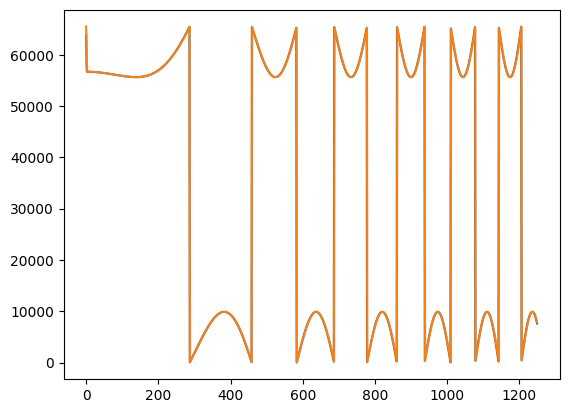

In [536]:
plt.plot(if_i[15:20000:16])
plt.plot(if_i2[0:20000:16])

np.uint16(33213)

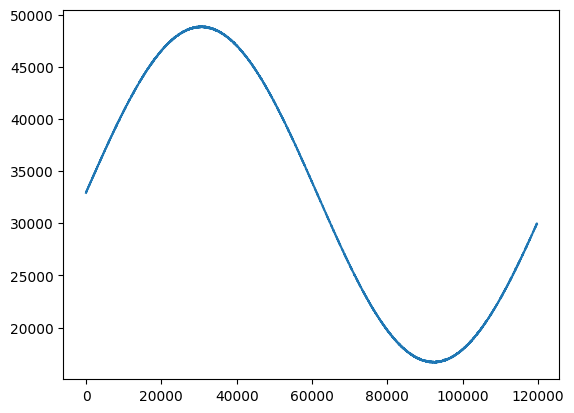

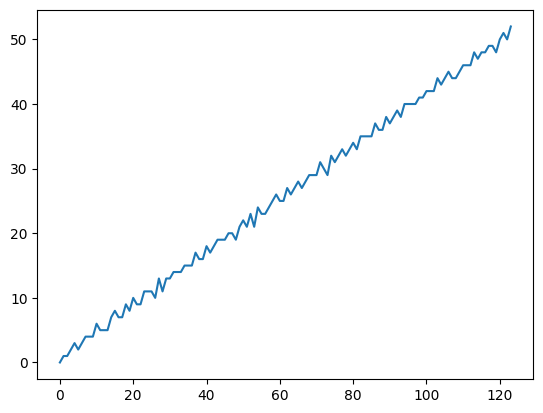

In [517]:
plt.plot(sig_demod_upsampled[300:])
plt.figure()
plt.plot(sig_demod2[79:2048:16].astype(np.int16))
np.max(sig_demod_upsampled[500:600])

In [33]:
594461264/(2**29)

1.1072703897953033

In [34]:
np.atan2((65535/2**29), (32767/2**29))

np.float64(1.1071548214214761)

In [36]:
594385738/(2**29)

1.1071297116577625